In [115]:
# 定义保存数据的类
import numpy as np

#定义类
class IPAccessData(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
#         self.ip_dict = ip_dict
#         self.ip_reserve_list = ip_reserve_list
#         self.data_scaler = data_scaler


In [116]:
time_window = 240
time_steps = 20
dimension = 32
n_class = 2

In [117]:
import pickle
# fp = open('iPAccessData_time_window_'+str(time_window)+'.pkl','rb',True)
fp = open('iPAccessData_count.pkl','rb',True)
iPAccessData = pickle.load(fp)
# X = iPAccessData.X
# labels = iPAccessData.y

In [118]:
iPAccessData.y.shape

(18662,)

In [119]:
#截取一部分数据（因为正常数据太多了）
X0 = iPAccessData.X[iPAccessData.y==0,:,:]
# random_select = np.random.choice(X0.shape[0], 6000) #随即选择200个数据
# X0 = X0[random_select]

X1 = iPAccessData.X[iPAccessData.y==1,:,:]

X2 = iPAccessData.X[iPAccessData.y==2,:,:]
# random_select = np.random.choice(X2.shape[0], 4000) #随即选择200个数据
# X2 = X2[random_select]


X = np.concatenate((X0, X1, X2), axis=0) #与异常标签数据合并
labels = np.concatenate((np.zeros(X0.shape[0]), np.ones(X1.shape[0]), np.zeros(X2.shape[0])) , axis=0) #与异常标签数据合并
print (X.shape)
print (labels)

(18662, 20, 32)
[ 0.  0.  0. ...,  0.  0.  0.]


In [120]:
import keras

y = keras.utils.to_categorical(labels, num_classes=n_class)

print(X.shape)
print(labels.shape)
print(y.shape)

(18662, 20, 32)
(18662,)
(18662, 2)


In [121]:
from sklearn.model_selection import train_test_split
X = X.reshape([-1,time_steps*dimension])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.50, random_state=888)

test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.5, random_state=888)

train_X = train_X.reshape([-1,time_steps,dimension])
test_X = test_X.reshape([-1,time_steps,dimension])
val_X = val_X.reshape([-1,time_steps,dimension])
print (train_X.shape, test_X.shape, val_X.shape)

(9331, 20, 32) (4665, 20, 32) (4666, 20, 32)


In [122]:
# 定义神经网络
# 原始数据--向量LSTM（64）--全连接Dense（64）--全连接Dense（2）

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(64, input_shape=(time_steps, dimension),name='lstm_layer'))  # returns a sequence of vectors of dimension 32
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu',name='dense1'))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_X, train_y, batch_size=64, epochs=100,validation_data=(val_X, val_y))
# score = model.evaluate(x_test, y_test, batch_size=16)

Train on 9331 samples, validate on 4666 samples
Epoch 1/10
9331/9331 [==============================] - 4s - loss: 0.2300 - acc: 0.9407 - val_loss: 0.1382 - val_acc: 0.9653
Epoch 2/10
9331/9331 [==============================] - 3s - loss: 0.1700 - acc: 0.9633 - val_loss: 0.1320 - val_acc: 0.9664
Epoch 3/10
9331/9331 [==============================] - 3s - loss: 0.1577 - acc: 0.9644 - val_loss: 0.1234 - val_acc: 0.9674
Epoch 4/10
9331/9331 [==============================] - 3s - loss: 0.1503 - acc: 0.9648 - val_loss: 0.1215 - val_acc: 0.9685
Epoch 5/10
9331/9331 [==============================] - 3s - loss: 0.1465 - acc: 0.9644 - val_loss: 0.1362 - val_acc: 0.9655
Epoch 6/10
9331/9331 [==============================] - 3s - loss: 0.1423 - acc: 0.9653 - val_loss: 0.1119 - val_acc: 0.9685
Epoch 7/10
9331/9331 [==============================] - 3s - loss: 0.1431 - acc: 0.9642 - val_loss: 0.1213 - val_acc: 0.9659
Epoch 8/10
9331/9331 [==============================] - 3s - loss: 0.1381 - a

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


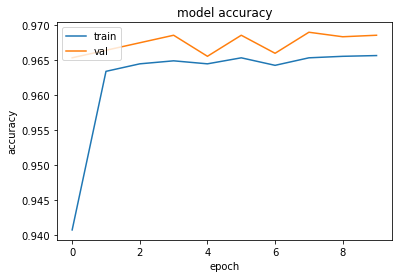

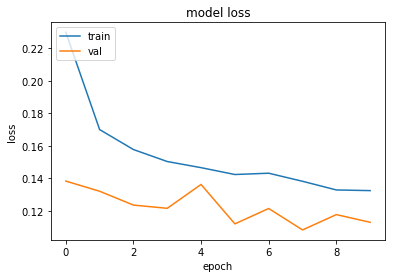

In [123]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [125]:
#每一个类别，进行识别率和F1-score验证
pred_y = model.predict(test_X, batch_size=32, verbose=0)

pred_idx = np.argmax(pred_y,axis=1)
test_idx = np.argmax(test_y,axis=1)

In [126]:
from sklearn.metrics import classification_report

print (classification_report(test_idx, pred_idx))
# print (test_generator.class_indices)

             precision    recall  f1-score   support

          0       0.97      1.00      0.98      3816
          1       0.99      0.84      0.91       849

avg / total       0.97      0.97      0.97      4665



In [19]:
# from keras.models import Model
# intermediate_layer_model = Model(inputs=model.input,
#                                  outputs=model.get_layer('dense1').output)

# intermediate_output = intermediate_layer_model.predict(test_X)

In [127]:
# from keras.models import load_model

model.save('single_layer_lstm.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
# model = load_model('my_model.h5')

In [233]:
false_negative = (pred_idx==0) & (test_idx==1) #被认为是正常，但是实际上是异常
false_positive = (pred_idx==1) & (test_idx==0) #被认为是异常，但是实际上正常

In [50]:
#读取之前的url_list数据，配合假阴性假阳性判断
class IPAccessInfo(object):
    def __init__(self, all_url_list, all_url_dict_list):
        self.all_url_list = all_url_list
        self.all_url_dict_list = all_url_dict_list
        
import pickle
fp = open('url_info.pkl','rb',True)
iPAccessInfo = pickle.load(fp)

In [94]:
false_negative_urls = [iPAccessInfo.all_url_list[i] for i,v in enumerate(false_negative) if v==True]
false_negative_urls  #被认为是正常，但是实际上是异常的，看看对不对吧

NameError: name 'iPAccessInfo' is not defined

In [52]:
false_positive_urls = [iPAccessInfo.all_url_list[i] for i,v in enumerate(false_positive) if v==True]
false_positive_urls  #被认为是异常，但是实际上是正常的，看看对不对吧

[['POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'GET common/.../patientList.do',
  'GET /.../patientinfo.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do',
  'POST /.../reserve.do'],
 ['GET common/.../arrangementList.do',
  'POST /.../getTimeList.do',
  'GET common/.../reserveConfirm.do',
  'POST /.../reserveConfirm.do'],
 ['GET common/.../arrangementList.do',
  'GET common/.../arrangementList.do',
  'GET common/.../login.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDept.do',
  'GET common/.../chooseExpert.do',
  'GET common/.../deptList.do',
  'POST /.../getDept.do',
  'GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do'],
 ['GET common/.../scheduleByDept.do',
  'POST /.../scheduleByDept.do',
  'POST /.../getDe